# Borehole rock-physics
## Investigating the accuracy of various rock-physics transforms using borehole data

In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import os
import sys
import numpy as np
from matplotlib import pyplot as plt
import lasio
import pandas as pd
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from subprocess import call
import seaborn as sns
import matplotlib.cm as cm
sns.set(color_codes=True)
from funcs import *

In [2]:
workdir = Path('../')
lasdir = workdir.joinpath('data','las_MPWSP')
auxdir=  workdir.joinpath('data','auxiliary')
figdir=  workdir.joinpath('work','figs')

### Create common masks and functions

In [3]:
# def mask_nonan(df,nan_col_list):
#     mask = df.notnull()
#     return mask.loc[:,nan_col_list].all(axis=1)

# def mask_noclay(df,nan_col_list):
#     return ~df.loc[mask_nonan(df,nan_col_list),'lith'].str.contains("C")

# def mask_SP_only(df,nan_col_list):
#     return df.loc[mask_nonan(df,nan_col_list),'lith']=="SP"

# def mask_stds(df,nstds,testcol,nan_col_list):
#     pop = df.loc[mask_nonan(df,nan_col_list),testcol]
#     return  np.logical_and(pop < np.mean(pop)+nstds*np.std(pop),
#                            pop > np.mean(pop)-nstds*np.std(pop))
# def mask_wherescreen(df,nan_col_list):
#     return  mask_nonan(df[df.screen.notnull()],nan_cols)
def export_tree(export_dir,reg,max_depth,predictors,prefix='BagTree_',**kwargs):
    #Export graphs
    from sklearn import tree
    fig_suffix = '{numlevels}lvls_{predictors}.png'.format(numlevels=max_depth,predictors='-'.join(predictors))
    tree.export_graphviz(reg,out_file=export_dir.joinpath('tree.dot').as_posix(),filled=True,rounded=True,**kwargs)
    call(['dot', '-Tpng', figdir.joinpath('tree.dot').as_posix(), '-o',
    export_dir.joinpath(prefix+fig_suffix).as_posix(), '-Gdpi=150'])
    return

def tds2rho_est(tds,m=.692826,b=-220.28):
    return 1e4*m/(tds-b)

def rho2tds_est(rho,m=.692826,b=-220.28):
    return 1e4*m/rho + b

def cond2rho(cond):
    return 1e4/cond
    
def nested_logicals(df,list_of_conditions,func=np.logical_and):
    '''
    Convenience function to nest numpy logical functions
        Input: 
            df
            list_of_conditions
            func: numpy function to be applied
        Output:
            logical mask for the given dataframe
        '''
    out = np.ones(len(list_of_conditions[0]),dtype=bool)
    for i in range(len(list_of_conditions)):
        out = func(out,list_of_conditions[i])
    return out

def interpIntervals(df,interp_cols,group_cols=['Well','Year'],dept_col='DEPT',interval=.5):
    '''
    Interpolates numerical values to a specified resolution (interval) 
    Meant for use with depth-registered well data
        Input:
            df: DataFrame
            interp_cols: list
            group_cols: list
            dept_col: str
            interval: numeric
        Output:
            DataFrame with interpolated rows
    '''
    frames = []
    for key,group in df.groupby(by=group_cols):

        all_cols = group.columns
        dup_cols=[col for col in all_cols if (col not in (interp_cols+[dept_col]))]

        #interpolation
        x_eval = np.arange(group.loc[:,dept_col].values[0],group.loc[:,dept_col].values[-1]+interval,interval)
        xp = group.loc[:,dept_col].values
        y_eval={}
        for col in interp_cols:
            yp = group.loc[:,col].values
            y_eval[col]=np.interp(x_eval,xp,yp)

        #create new DF
        df_out = pd.DataFrame(columns=all_cols)
        df_out = df_out.append([df.loc[group.index[0],dup_cols]]*len(x_eval))
        for col in interp_cols:
            df_out.loc[:,col] = y_eval[col]
        df_out.loc[:,dept_col] = x_eval

        #concatenate frames
        frames.append(df_out)
    return pd.concat(frames).reset_index(drop=True)

def concat_dfs(dfs):
    dfs = [sc_df_interp,df2]
    new_dfs = []
    maxind= 0

    for df in dfs:
        df_index = df.index.values + maxind + 1
        maxind = np.max(df_index)
        df.loc[:,'new_index'] = df_index
        df.set_index('new_index',inplace=True)
        new_dfs.append(df)
    return pd.concat(new_dfs,axis=0,sort=True)

def update_df2():
    return df.reset_index().rename(columns={"level_0": "Well"})

def update_FBS(df,TDS_col,breaks=[0,3000,10000]):
    FBS = np.zeros(len(df))
    FBS[df.loc[:,TDS_col].isna()] = np.nan
    breaks = np.r_[breaks,1e10]
    for i in range(len(breaks[:-1])):
        FBS[np.logical_and(df.loc[:,TDS_col] > breaks[i], df.loc[:,TDS_col] < breaks[i+1])] = i
    return df.assign(FBS=FBS)

def bin_wiggle(vec,binsize=.1):
    return np.random.uniform(vec-binsize/2,vec+binsize/2)

# mask_noclay = np.logical_or(df.loc[:,'lith'].str.contains("C"),df.loc[:,'lith'].isna())
nan_cols = ['FRES','lith','RILD']

### Import data exported from WellProcessing.ipynb

In [4]:
importSoquel = True
if importSoquel:
    df =  pd.read_pickle(lasdir.joinpath('allMWs_SC'))
    df_ind =  pd.read_pickle(lasdir.joinpath('allMWs_SC_ind'))
else:
    df =  pd.read_pickle(lasdir.joinpath('allMWs'))
    df_ind =  pd.read_pickle(lasdir.joinpath('allMWs_ind'))

df2 =update_df2()
MPWSPnames = df2.loc[~df2.FRES.isna(),'Well'].unique()
MWnames = df.index.levels[0].values

In [5]:
### Aquifer number

In [6]:
aq_groupnames = df[df.AquiferGroup.notna()].AquiferGroup.unique()
aq_names = df[df.Aquifer.notna()].Aquifer.unique()
aq_names.sort()
aq_groupnum = -1*np.ones(len(df),dtype='Int32')
aqnum = -1*np.ones(len(df),dtype='Int32')

for i,nam in enumerate(aq_groupnames):
    aq_groupnum[df.AquiferGroup == nam] = i
df=df.assign(aq_groupnum=aq_groupnum)

for i,aq in enumerate(aq_names):
    aqnum[df.Aquifer == aq_names[i]] = i
df=df.assign(aqnum=aqnum)

In [7]:
# df.loc['MW-4D'].loc[328:,'RILD']=np.nan
df2 = update_df2()
wellids = df2.Well.unique()
welldict = {}
for i,nam in enumerate(wellids):
    welldict[nam]=i

df=update_FBS(df,'TDS1')
df2=update_df2()

In [8]:
from scipy import stats
def x_y_regression(xin,yin,cin,msk=None,plotslp=True,slpname='F',kdeplot=False,plotone2one=False,**kwargs):
    if msk is None:
        x=xin
        y=yin
        c=cin
    else:
        x=xin[msk]
        y=yin[msk]
        c=cin[msk]
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    plt.set_cmap('viridis_r')
    f,ax = plt.subplots(1,figsize=(5,4))
    if kdeplot:
        sns.kdeplot(x,y)
    plt.scatter(x,y,c=c,**kwargs)
    plt.plot(x,slope*x + intercept,':k',label='L2 best fit')
    if plotone2one:
        one2one = np.linspace(x.min(),x.max())
        plt.plot(one2one,one2one,'k',label='y=x')
    if plotslp:
        plt.text(0.05,.80,'{} = {:.2f} \n$R^2$ = {:.2f} \nNormErr = {:.2f}%'
                 .format(slpname,slope,r_value**2,np.round(np.linalg.norm(y-x*slope)/np.linalg.norm(y)*100,1)),transform=ax.transAxes)
#         plt.text(0.05,.80,'{} = {:.2f} \n$R^2$ = {:.2f} \nRMSE = {:.2f}'
#                  .format(slpname,slope,r_value**2,np.sqrt(np.mean((y-x*slope)**2))),transform=ax.transAxes)
    else:
        plt.text(x.max()-(x.max()-x.min())*.75,y.max(),'$R^2$ = {:.2f} \nRMSE = {:.2f}'
                 .format(r_value**2,np.sqrt(np.mean((y-x*slope)**2))))
    return f,ax

##### Interestingly, the classification tree, while it doesn't reduce the variance in the model, it does significantly reduce the bias, changing the slope from ~0.82 to ~0.96

### Bagging Trees for an estimate of uncertainty

In [9]:
def bagged_trees2(df,predicted,predictors,estimator=DecisionTreeRegressor,
                 train_ratio=.20,n_repeat=10,train_test_cols=None,verbose=True,**kwargs):
    #Separate training from test data
    y_all = df.loc[:,predicted]
    df_train, df_test, y_train, y_test = train_test_split(df, y_all, test_size=train_ratio)

    if train_test_cols is  None:
        train_test_cols = [predicted,predicted]
    else:
        y_test = y_test.loc[:,[train_test_cols[1]]]

    X_test = df_test.loc[:,predictors]
    regs = []
    X_train = []
    y_train = []
    for i in range(n_repeat):
        samp = resample(df_train,replace=True)
        X_train.append(samp.loc[:,predictors])
        y_train.append(samp.loc[:,[train_test_cols[0]]])

    # Compute predictions
    y_predict = np.zeros((len(y_test), n_repeat))

    for i in range(n_repeat):
        regs.append(estimator(**kwargs))
        regs[-1].fit(X_train[i], y_train[i])
        y_predict[:, i] = regs[-1].predict(X_test)


    y_est = y_predict.mean(axis=1)
    y_error = np.zeros(y_test.size)

    # Bias^2 + Variance + Noise decomposition of the mean squared error
    y_error = np.power(y_test.values - y_predict,2).mean(axis=1)
    y_noise = 0 # didn't bootstrap the test values np.var(y_test.values)
    y_bias = (y_test.values.flatten() - np.mean(y_predict, axis=1))**2
    y_var = np.var(y_predict,axis=1)
    
    
    if verbose:
        print("{0:.4f} (MSE) = {1:.4f} (bias^2)"
              "+ {2:.4f} (var)".format(np.mean(y_error),
                                       np.mean(y_bias),
                                       np.mean(y_var)))
        print("{0:.4f} (MSE) = {1:.2f}% (bias^2)"
              "+ {2:.2f}% (var)".format(np.mean(y_error),
                                       100*np.mean(y_bias)/(np.mean(y_bias)+np.mean(y_var)),
                                       100*np.mean(y_var)/(np.mean(y_bias)+np.mean(y_var))))
    return regs,y_predict,(df_train, df_test, X_train, X_test, y_train, y_test)

163.1511 (MSE) = 162.2505 (bias^2)+ 0.9006 (var)
163.1511 (MSE) = 99.45% (bias^2)+ 0.55% (var)


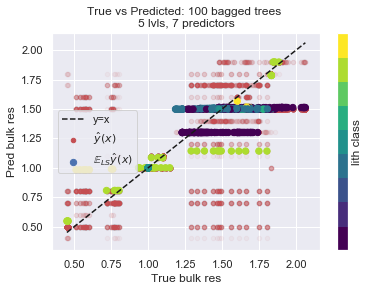

<Figure size 432x288 with 0 Axes>

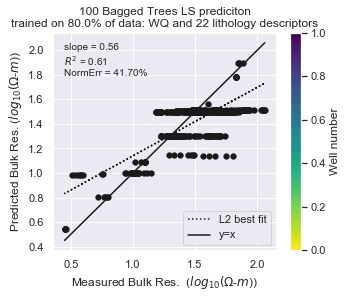

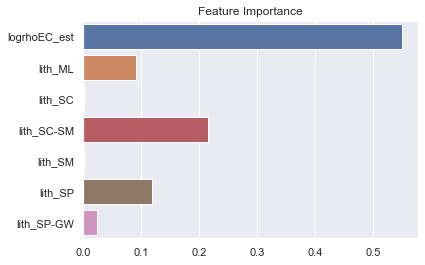

In [10]:
#Predict from water quality samples and lith
np.random.seed(1)
n_repeat = 100       # Number of iterations for computing expectations
train_ratio = .20
max_depth = 5
predicted = ['logrild_bin','logrild']
train_test_cols = ['logrild_bin','logrild']
# train_test_cols = None
predictors = ['logrhoEC_est']
estimator= DecisionTreeClassifier

df=update_FBS(df,'TDS1')

mask = nested_logicals(df,(df.RILD.notnull(),df.Rw_est.notnull(),df.lith.notnull(),df.Region=='Soquel'),func=np.logical_and)
df_testing = df[mask]


#     df_testing = df2[nested_logicals(df2,list_of_conditions,func=np.logical_and)]

##########################################

df_testing = df_testing.assign(logrhoEC1f = np.log10(cond2rho(df_testing.loc[:,'EC1f'])))
df_testing = df_testing.assign(logrhoEC_est = np.log10(df_testing.loc[:,'Rw_est']))

df_testing = df_testing.assign(logrild = np.log10(df_testing.RILD))
df_testing = df_testing.assign(logrild_bin = (np.round(np.log10(df_testing.RILD),1)*10).values.astype(int))
df_testing = df_testing.assign(logrilm = np.log10(df_testing.RILM))
df_testing = df_testing.assign(logfres = np.log10(df_testing.FRES))
df_testing = df_testing.sort_values(by='lith')
ohc = df_testing.loc[:,['lith']]
ohc =  pd.get_dummies(ohc,drop_first=True)
predictors = np.concatenate((predictors,ohc.columns.values))
df_testing = pd.get_dummies(df_testing,drop_first=False)

regs,y_predict,(df_train, df_test, X_train, X_test, y_train, y_test) = bagged_trees2(
    df_testing,predicted,predictors,
    estimator=estimator,
    train_ratio=train_ratio,
    train_test_cols=train_test_cols,
    n_repeat=n_repeat,
    max_depth=max_depth)

y_predict /=10
y_est = y_predict.mean(axis=1)


#Plot
f,ax = plt.subplots()
s=20
spreadcolor= "r"
cmap = cm.get_cmap('viridis',9)  
for i in range(n_repeat):
        plt.scatter(y_test,y_predict[:,i],c=spreadcolor,s=s,alpha=.05)
plt.scatter(y_test, y_est, c=spreadcolor,s=s,
         label=r"$\^y(x)$")
p = plt.scatter(y_test, y_est, c=df_test.lithnum,
         label=r"$\mathbb{E}_{LS} \^y(x)$",s=2*s,cmap=cmap)
one2one = np.linspace(y_test.min(),y_test.max())
plt.plot(one2one,one2one,'k--',label='y=x')
cb = f.colorbar(p,ax=ax,ticks=np.arange(len(predictors)))
cb.set_label('lith class', rotation=90)
# cb.ax.set_ylim([-.1,1.1])
pred_label = [pred[5:] for pred in predictors[1:]]
cb.ax.set_yticklabels(np.hstack(('not',pred_label)).astype(str))  # vertically oriented colorbar

plt.xlabel('True bulk res')
plt.ylabel('Pred bulk res')
plt.title('True vs Predicted: {} bagged trees \n'
          '{} lvls, {} predictors'.format(n_repeat,
                                          max_depth,
                                          len(predictors)))
plt.legend()
plt.show()

#Pred vs True
f,ax = x_y_regression(y_test.values.squeeze(),
                      y_est,
#                       df_test.aqnum,
#                       [int(nam[3]) for nam in pd.DataFrame(X_test.index.to_list(),columns=['Well','DEPT'])['Well']],
                      'k',
                      plotslp=True,slpname='slope',
                      plotone2one=True,
                      cmap=cmap,
                      edgecolors='k',
                      linewidths=0.25);


if len(predictors)>2:
    predictors_text_suffix = ' +...'
else:
    predictors_text_suffix = ''
predictors_text = ' + '.join(predictors[:2]) + predictors_text_suffix
ax.set_title('{} Bagged Trees LS prediciton\ntrained on {}% of data: WQ and 22 lithology descriptors'
             .format(n_repeat,(1-train_ratio)*100,predictors_text))
plt.xlabel('Measured Bulk Res.  ($log_{10}(\Omega$-$m$))')
plt.ylabel('Predicted Bulk Res. ($log_{10}(\Omega$-$m$))')
ax.legend(loc='lower right')
cb = f.colorbar(ax.collections[0],ax=ax)
cb.set_label('Well number', rotation=90)
# # cb.ax.set_ylim([-.1,1.1])
# pred_label = [pred for pred in predictors[1:]]
# cb.ax.set_yticklabels(np.hstack(('not',pred_label)).astype(str))  # vertically oriented colorbar
plt.savefig(figdir.joinpath('BaggedTreeLS_WQ_22lith.png'),bbox_inches='tight',dpi=300)
plt.show();


scores = 0
for i in range(n_repeat):
    scores += regs[i].feature_importances_
scores /= n_repeat
sns.barplot(x=scores,y=X_test.columns)
plt.title('Feature Importance');


#### Bagged Classifiers trained on:
###### -Resistivity of water quality sample
###### -4 lithology classifiers

In [11]:
# #Predict from water quality samples and lith
np.random.seed(1)
n_repeat = 100       # Number of iterations for computing expectations
train_ratio = .20
max_depth = 5
predicted = ['logrild_bin','logrild']
train_test_cols = ['logrild_bin','logrild']
# train_test_cols = None
# predictors = ['logrhoEC1f','C','M','S']
predictors = ['logrhoEC1f','C','M','S']

estimator= DecisionTreeClassifier

df_testing = df[np.logical_and(np.logical_and(
    df.RILD.notnull(),df.EC1f.notnull()),df.lith.notnull())]
##########################################

df_testing = df_testing.assign(logrhoEC1f = np.log10(cond2rho(df_testing.loc[:,'EC1f'])))
df_testing = df_testing.assign(logrild = np.log10(df_testing.RILD))
df_testing = df_testing.assign(logrild_bin = (np.round(np.log10(df_testing.RILD),1)*10).values.astype(int))
df_testing = df_testing.assign(logfres = np.log10(df_testing.FRES))




regs,y_predict,(df_train, df_test, X_train, X_test, y_train, y_test) = bagged_trees2(
    df_testing,predicted,predictors,
    estimator=estimator,
    train_ratio=train_ratio,
    train_test_cols=train_test_cols,
    n_repeat=n_repeat,
    max_depth=max_depth)

y_predict /=10
y_est = y_predict.mean(axis=1)


#Plot
f,ax = plt.subplots()
s=20
spreadcolor= "r"
cmap = cm.get_cmap('viridis',9)  
for i in range(n_repeat):
        plt.scatter(y_test,y_predict[:,i],c=spreadcolor,s=s,alpha=.05)
plt.scatter(y_test, y_est, c=spreadcolor,s=s,
         label=r"$\^y(x)$")
p = plt.scatter(y_test, y_est, c=df_test.lithnum,
         label=r"$\mathbb{E}_{LS} \^y(x)$",s=2*s,cmap=cmap)
one2one = np.linspace(y_test.min(),y_test.max())
plt.plot(one2one,one2one,'k--',label='y=x')
cb = f.colorbar(p,ax=ax,ticks=np.arange(len(predictors)))
cb.set_label('lith class', rotation=90)
# cb.ax.set_ylim([-.1,1.1])
pred_label = [pred[5:] for pred in predictors[1:]]
cb.ax.set_yticklabels(np.hstack(('not',pred_label)).astype(str))  # vertically oriented colorbar

plt.xlabel('True bulk res')
plt.ylabel('Pred bulk res')
plt.title('True vs Predicted: {} bagged trees \n'
          '{} lvls, {} predictors'.format(n_repeat,
                                          max_depth,
                                          len(predictors)))
plt.legend()
plt.show()

#Pred vs True
f,ax = x_y_regression(y_test.values.squeeze(),
                      y_est,
                      'k',
#                       df_test.aqnum,
#                       [int(nam[3]) for nam in pd.DataFrame(X_test.index.to_list(),columns=['Well','DEPT'])['Well']],
                      plotslp=True,slpname='slope',
                      plotone2one=True,
                      cmap=cmap,
                      edgecolors='k',
                      linewidths=0.25);


if len(predictors)>2:
    predictors_text_suffix = ' +...'
else:
    predictors_text_suffix = ''
predictors_text = ' + '.join(predictors[:2]) + predictors_text_suffix
ax.set_title('{} Bagged Trees LS prediciton\ntrained on {}% of data: WQ and 4 lithology descriptors'
             .format(n_repeat,(1-train_ratio)*100,predictors_text))
plt.xlabel('Measured Bulk Res.  ($log_{10}(\Omega$-$m$))')
plt.ylabel('Predicted Bulk Res. ($log_{10}(\Omega$-$m$))')
ax.legend(loc='lower right')
cb = f.colorbar(ax.collections[0],ax=ax)
cb.set_label('Well number', rotation=90)
# # cb.ax.set_ylim([-.1,1.1])
# pred_label = [pred for pred in predictors[1:]]
# cb.ax.set_yticklabels(np.hstack(('not',pred_label)).astype(str))  # vertically oriented colorbar
plt.savefig(figdir.joinpath('BaggedTreeLS_WQ_4lith.png'),bbox_inches='tight',dpi=300)
plt.show();


scores = 0
for i in range(n_repeat):
    scores += regs[i].feature_importances_
scores /= n_repeat
sns.barplot(x=scores,y=X_test.columns)
plt.title('Feature Importance');

/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in log10


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

#### Bagged Classifiers trained on:
###### -Resistivity of water quality sample
###### -2 lithology classifiers

In [12]:
# #Predict from water quality samples and lith
np.random.seed(1)
n_repeat = 100       # Number of iterations for computing expectations
train_ratio = .20
max_depth = 5
predicted = ['logrild_bin','logrild']
train_test_cols = ['logrild_bin','logrild']
# train_test_cols = None
predictors = ['logrhoEC1f','Cb']
estimator= DecisionTreeClassifier

df_testing = df[np.logical_and(np.logical_and(
    df.RILD.notnull(),df.EC1f.notnull()),df.lith.notnull())]
##########################################

df_testing = df_testing.assign(logrhoEC1f = np.log10(cond2rho(df_testing.loc[:,'EC1f'])))
df_testing = df_testing.assign(logrild = np.log10(df_testing.RILD))
df_testing = df_testing.assign(logrild_bin = (np.round(np.log10(df_testing.RILD),1)*10).values.astype(int))
df_testing = df_testing.assign(logfres = np.log10(df_testing.FRES))




regs,y_predict,(df_train, df_test, X_train, X_test, y_train, y_test) = bagged_trees2(
    df_testing,predicted,predictors,
    estimator=estimator,
    train_ratio=train_ratio,
    train_test_cols=train_test_cols,
    n_repeat=n_repeat,
    max_depth=max_depth)

y_predict /=10
y_est = y_predict.mean(axis=1)


#Plot
f,ax = plt.subplots()
s=20
spreadcolor= "r"
cmap = cm.get_cmap('viridis',9)  
for i in range(n_repeat):
        plt.scatter(y_test,y_predict[:,i],c=spreadcolor,s=s,alpha=.05)
plt.scatter(y_test, y_est, c=spreadcolor,s=s,
         label=r"$\^y(x)$")
p = plt.scatter(y_test, y_est, c=df_test.lithnum,
         label=r"$\mathbb{E}_{LS} \^y(x)$",s=2*s,cmap=cmap)
one2one = np.linspace(y_test.min(),y_test.max())
plt.plot(one2one,one2one,'k--',label='y=x')
cb = f.colorbar(p,ax=ax,ticks=np.arange(len(predictors)))
cb.set_label('lith class', rotation=90)
# cb.ax.set_ylim([-.1,1.1])
pred_label = [pred[5:] for pred in predictors[1:]]
cb.ax.set_yticklabels(np.hstack(('not',pred_label)).astype(str))  # vertically oriented colorbar

plt.xlabel('True bulk res')
plt.ylabel('Pred bulk res')
plt.title('True vs Predicted: {} bagged trees \n'
          '{} lvls, {} predictors'.format(n_repeat,
                                          max_depth,
                                          len(predictors)))
plt.legend()
plt.show()

#Pred vs True
f,ax = x_y_regression(y_test.values.squeeze(),
                      y_est,
                      'k',
#                       [int(nam[3]) for nam in pd.DataFrame(X_test.index.to_list(),columns=['Well','DEPT'])['Well']],
                      plotslp=True,slpname='slope',
                      plotone2one=True,
                      cmap=cmap,
                      edgecolors='k',
                      linewidths=0.25);


if len(predictors)>2:
    predictors_text_suffix = ' +...'
else:
    predictors_text_suffix = ''
predictors_text = ' + '.join(predictors[:2]) + predictors_text_suffix
ax.set_title('{} Bagged Trees LS prediciton\ntrained on {}% of data: WQ and 2 lithology descriptors'
             .format(n_repeat,(1-train_ratio)*100,predictors_text))
plt.xlabel('Measured Bulk Res.  ($log_{10}(\Omega$-$m$))')
plt.ylabel('Predicted Bulk Res. ($log_{10}(\Omega$-$m$))')
ax.legend(loc='lower right')
cb = f.colorbar(ax.collections[0],ax=ax)
cb.set_label('Well number', rotation=90)


# plt.savefig(figdir.joinpath('BaggedTreeLS_WQ_2lith.png'),bbox_inches='tight',dpi=300)
# plt.show();

plt.figure()
scores = 0
for i in range(n_repeat):
    scores += regs[i].feature_importances_
scores /= n_repeat
sns.barplot(x=scores,y=X_test.columns)
plt.title('Feature Importance');

/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log10


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

#### Bagged Classifiers trained on:
###### -Resistivity of water quality sample
###### -Binary lithology
###### -Aquifer number
###### -Convolved lithology: 2.5-ft-wide moving filter of binary lithology (Sand=1,Clay=0)

/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log10


66.5453 (MSE) = 65.4987 (bias^2)+ 1.0466 (var)
66.5453 (MSE) = 98.43% (bias^2)+ 1.57% (var)


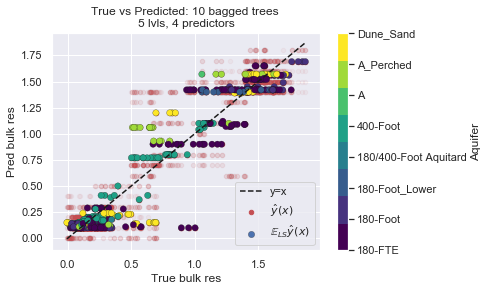

<Figure size 432x288 with 0 Axes>

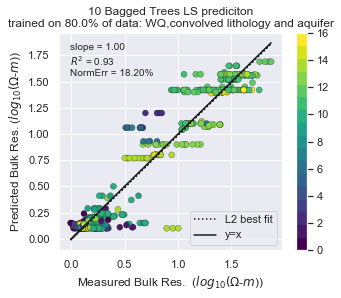

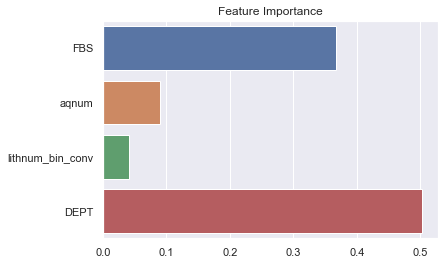

In [15]:
np.random.seed(1)

n_repeat = 10      # Number of iterations for computing expectations
train_ratio = .20
max_depth = 5


####Choose the input data set#########
# ## Predict from FRES and lith
# predicted = ['logrild']
# predictors = ['logfres','Sb']
# df_testing = df[np.logical_and(np.logical_and(df.RILD.notnull(),~np.isnan(np.log(df.FRES.values))),df.lith.notnull())]

#Predict from water quality samples and lith
predicted = ['logrild_bin','logrild']
train_test_cols=predicted

predictors = ['FBS','aqnum','lithnum_bin_conv','DEPT']
colorcolumn = 'aqnum'
estimator=DecisionTreeClassifier
# df_testing = df[np.logical_and(np.logical_and(df.RILD.notnull(),df.EC1f.notnull()),df.lith.notnull())]

# mask = nested_logicals(df2,(df2.RILD.notnull(),df2.EC1f.notnull(),df2.lith.notnull(),df2.Region=='Marina'),func=np.logical_and)
# df_testing = df[mask]

# df_testing = df2[np.logical_and(np.logical_and(df2.RILD.notnull(),df2.EC1f.notnull()),df2.lith.notnull())]

#######################################

df_testing = df_testing.assign(logrhoEC1f = np.log10(cond2rho(df_testing.loc[:,'EC1f'])))
df_testing = df_testing.assign(logrild = np.log10(df_testing.RILD))
df_testing = df_testing.assign(logrild_bin = (np.round(np.log10(df_testing.RILD),1)*10).values.astype(int))
df_testing = df_testing.assign(logfres = np.log10(df_testing.FRES))


list_of_conditions = (df2.RILD.notnull(),
                      df2.FBS.notnull(),
                      df2.lith.notnull(),
                      df2.Y.notnull(),
                      df2.Region=='Marina')

conditions = [df_testing.loc[:,predictor].notnull() for predictor in predictors]
df_testing = df_testing.loc[nested_logicals(df_testing,list_of_conditions,func=np.logical_and)]



regs,y_predict,(df_train, df_test, X_train,X_test,y_train, y_test) = bagged_trees2(df_testing,predicted,predictors,
                              train_ratio=train_ratio,
                              train_test_cols=train_test_cols,
                              n_repeat=n_repeat,
                              estimator=estimator,
                              max_depth=max_depth)

y_predict /=10
y_est = y_predict.mean(axis=1)

#Plot
f,ax = plt.subplots()
s=20
spreadcolor= "r"
cmap = cm.get_cmap('viridis',len(df_testing.aqnum.unique()))  
for i in range(n_repeat):
        plt.scatter(y_test,y_predict[:,i],c=spreadcolor,s=s,alpha=.05)
y_est = y_predict.mean(axis=1)



plt.scatter(y_test, y_est, c=spreadcolor,s=s,
                label=r"$\^y(x)$")
p = plt.scatter(y_test, y_est, c=df_test.loc[:,colorcolumn],
                label=r"$\mathbb{E}_{LS} \^y(x)$",s=2*s,
                cmap=cmap,edgecolors='k',linewidth=.25)

one2one = np.linspace(y_test.min(),y_test.max())
plt.plot(one2one,one2one,'k--',label='y=x')
cb = f.colorbar(p,ax=ax)#,ticks=np.arange(len(aq_names)))
cb.set_label('Aquifer', rotation=90)
cb.set_ticks(np.arange(len(aq_names)))
cb.ax.set_yticklabels(aq_names)  # vertically oriented colorbar


plt.xlabel('True bulk res')
plt.ylabel('Pred bulk res')
plt.title('True vs Predicted: {} bagged trees \n'
          '{} lvls, {} predictors'.format(n_repeat,
                                          max_depth,
                                          len(predictors)))
plt.legend()
plt.show()

#Pred vs True
c= [welldict[nam] for nam in df_test.Well.values]
cmap = cm.get_cmap('viridis',len(np.unique(c)))

f,ax = x_y_regression(y_test.values.squeeze(),
                      y_est,
                      c,
                      plotslp=True,slpname='slope',
                      edgecolors='k',linewidth=.25,cmap=cmap)#,vmin=25,vmax=100);
one2one = np.linspace(y_test.min(),y_test.max())
plt.plot(one2one,one2one,'k',label='y=x')
if len(predictors)>2:
    predictors_text_suffix = ' +...'
else:
    predictors_text_suffix = ''
predictors_text = ' + '.join(predictors[:2]) + predictors_text_suffix
ax.set_title('{} Bagged Trees LS prediciton\ntrained on {}% of data: WQ,convolved lithology and aquifer'
             .format(n_repeat,(1-train_ratio)*100,predictors_text))
plt.xlabel('Measured Bulk Res.  ($log_{10}(\Omega$-$m$))')
plt.ylabel('Predicted Bulk Res. ($log_{10}(\Omega$-$m$))')
ax.legend(loc='lower right')
cb = f.colorbar(ax.collections[0])
# cb = f.colorbar(ax.collections[0],ax=ax,ticks=np.arange(len(predictors)))
# cb.set_label('Reduced lith class', rotation=90)
# cb.ax.set_ylim([-.1,1.1])
# cb.ax.set_yticklabels(np.hstack(('not',predictors[1:])).astype(str))  # vertically oriented colorbar
# plt.savefig(figdir.joinpath('BaggedTreeLS_WQ_lithconv_aqnum.png'),bbox_inches='tight',dpi=300)
plt.show();

scores = 0
for i in range(n_repeat):
    scores += regs[i].feature_importances_
scores /= n_repeat
sns.barplot(x=scores,y=X_test.columns)
plt.title('Feature Importance');
# plt.savefig(figdir.joinpath('FeatureImportance.png'),bbox_inches='tight',dpi=300)
# export_tree(figdir,regs[0],max_depth=5,predictors=predictors,prefix='Tree_',feature_names=predictors)

### Aakash's suggestions
--train on some wells, predict the remaining

--train on different combinations (or grouped depth intervals)

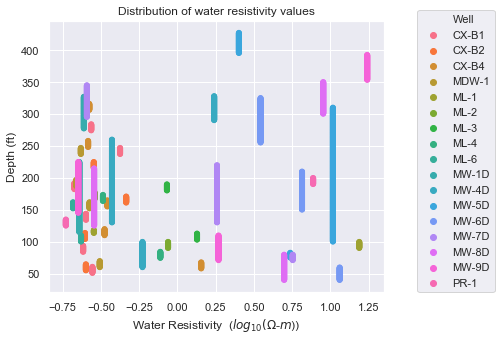

In [806]:
f,ax = plt.subplots(figsize=(6,5))
sns.scatterplot(data=df_testing,x='logrhoEC1f',y='DEPT',hue='Well',ax=ax,linewidth=0)
plt.legend(loc=(1.1, 0))
plt.xlabel('Water Resistivity  ($log_{10}(\Omega$-$m$))')
plt.ylabel('Depth (ft)')
plt.title('Distribution of water resistivity values')
plt.savefig(figdir.joinpath('WaterResVsDepth.png'),dpi=300,bbox_inches='tight')

### Slicing data different ways: 
#### Holding out one well to predict
#### Holding out one screened interval to predict

### Cross-validation: Train on all wells, hold out one for testing

In [16]:
def pred_ints(estimator, X, pred_mult=.10,percentile=95):
    preds = []
    for pred in estimator.estimators_:   
        preds.append(pred.predict(X))    
    preds = np.r_[preds]*pred_mult
    err_down = np.percentile(preds, (100 - percentile) / 2. ,axis=0)
    err_up = np.percentile(preds, 100 - (100 - percentile) / 2.,axis=0)
    return err_down, err_up


def make_class_weight(y_train,class_list):
    class_weight = {}
    for c in y_train.unique():
        if c in class_list:
            class_weight[c] = 10
        else:
            class_weight[c] = 1
    return class_weight

In [17]:
from sklearn.decomposition import PCA,KernelPCA
from sklearn.preprocessing import StandardScaler


def standardize(data,colnames=None,df_concat=None):
    scaler = StandardScaler()
    scaler.fit(data)
    data_trans = scaler.transform(data,)

    if df_concat is not None:
        cols = ['scaled'+str(col) for col in colnames]
        df_decomp = pd.DataFrame(data=data_trans,columns=cols,index=df_concat.index)
        df_concat = pd.concat((df_concat,df_decomp),axis=1)
        return df_concat,cols
    else:
        return data_decomp
    
def standardize_pca(data,pcaobj=PCA,  n_components=3,df_concat=None,**kwargs):
    scaler = StandardScaler()
    scaler.fit(data)
    data_trans = scaler.transform(data,)


#     pca = PCA(n_components=n_components)
    pca = pcaobj(n_components=n_components,**kwargs)
    data_decomp = pca.fit_transform(data_trans)
#     data_decomp = (pca.components_ @ data_trans.T).T
#     data_decomp = pca.components_
    if df_concat is not None:
        cols = ['pca'+str(i) for i in range(n_components)]
        df_decomp = pd.DataFrame(data=data_decomp,columns=cols,index=df_concat.index)
        df_concat = pd.concat((df_concat,df_decomp),axis=1)
        return df_concat,cols
    else:
        return pca.components_



In [18]:
from sklearn.linear_model import BayesianRidge,SGDRegressor


In [19]:
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,GradientBoostingClassifier,RandomForestRegressor,AdaBoostClassifier

df = update_FBS(df,'TDS1',breaks=np.arange(0,40000,3000))
df2 = update_df2()

np.random.seed(1)

n_repeat = 100   # Number of iterations for computing expectations
max_depth = 20
n_estimators = n_repeat
pcaobj = PCA

n_components = 4
max_features=3
####Choose the input data set#########
#Predict from water quality samples and lith
predicted = 'logrild_spline'

predictors = ['logrhoEC_est','aq_groupnum','X','Y','C','M','G','S','DEPT']
colorcolumn = 'aq_groupnum'

# class_list = [-16,-17,-18,-19]


# estimator=BaggingClassifier(DecisionTreeClassifier(
#     max_depth=max_depth,max_leaf_nodes=100),n_estimators=n_estimators,bootstrap_features=False)
# estimator = DecisionTreeRegressor(max_depth=max_depth,criterion='mae')
# estimator=GradientBoostingClassifier(n_estimators=n_estimators,max_depth=5,max_features=n_components)
# estimator=RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth)
# estimator=RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,min_samples_leaf=1,max_features=max_features)
# estimator=BayesianRidge(n_iter=1000,tol=.0001)

estimator = BaggingRegressor(DecisionTreeRegressor(max_depth=max_depth,criterion='mae'),n_estimators=n_estimators)
# estimator=RandomForestRegressor(n_estimators=n_estimators,max_depth=max_depth,min_samples_leaf=1,oob_score=False,max_features=max_features,criterion='mae')


y_preds = []
y_tests = []
y_color = []
errs = []
estimators = []
df_testing = df2
df_testing = df_testing.assign(DEPT_bin = (np.round(df_testing.DEPT/100,0)*100).astype(np.int))
# df_testing = df_testing.assign(logrhoEC_est = np.log10(df_testing.loc[:,'Rw_est']))
df_testing = df_testing.assign(Region_bin = df_testing.loc[:,'Region']=='Marina')
df_testing = df_testing.assign(logrhoEC1f = np.log10(cond2rho(df_testing.loc[:,'EC1f'])))
df_testing = df_testing.assign(logrild = np.log10(df_testing.RILD))
df_testing = df_testing.assign(logrild_bin = (np.round(np.log10(df_testing.RILD),1)*10).values.astype(int))
df_testing = df_testing.assign(logcild_bin = np.round(np.log10(1/df_testing.RILD)*10,0))
df_testing = df_testing.assign(logcild = np.log10(1/df_testing.RILD))

df_testing = df_testing.assign(cild_bin = np.round(1/df2.RILD*10,0))
df_testing = df_testing.assign(cond_est = 1/tds2rho_est(df2.TDS1))
df_testing = df_testing.assign(cond_est_bin = np.round( (df_testing.cond_est /1).astype(np.float),0)*1)
df_testing = df_testing.assign(logcond_est = np.log10((df_testing.cond_est).astype(np.float) ))
df_testing = df_testing.assign(logrhoEC_est = np.log10(tds2rho_est(df_testing.TDS1).astype(np.float)))

df_testing = df_testing.assign(logrild_conv_bin = (np.round(df_testing.logrild_conv,1)*10).values.astype(int))
df_testing = df_testing.assign(logfres = np.log10(df_testing.FRES))

list_of_conditions = (df2.RILD.notnull(),
                      df2.FBS.notnull(),
                      df2.lith.notnull(),
                      df2.Y.notnull(),
                      df2.Region=='Marina')

conditions = [df_testing.loc[:,predictor].notnull() for predictor in predictors]
df_testing = df_testing.loc[nested_logicals(df_testing,list_of_conditions,func=np.logical_and)]


# df_testing = df_testing.loc[df_testing.lithnum_bin_conv==1,:]

# # ##### Standardize, PCA
# data = df_testing.loc[:,predictors]
# df_testing,predictors = standardize_pca(data,pcaobj=pcaobj, n_components=n_components,df_concat=df_testing)
# df_testing,predictors = standardize(data,colnames=predictors,df_concat=df_testing)


# ###### Add in all lith descriptors
# df_testing = df_testing.sort_values(by='lith')
# ohc = df_testing.loc[:,['lith']]
# ohc =  pd.get_dummies(ohc,drop_first=False)
# predictors = np.concatenate((predictors,ohc.columns.values))
# df_testing = pd.concat((df_testing,ohc),axis=1)

# #######################
allwells = df_testing.Well.unique()

print('Wells with available data:',allwells)
for nam in allwells:
    testwell = nam
    print('testing on',nam)
    trainwells = [wellid for wellid in allwells if wellid!=testwell]

    df_train = df_testing.loc[df_testing.Well.isin(trainwells)]
    df_test = df_testing.loc[df_testing.Well==testwell]

    X_train = df_train.loc[:,predictors]
    y_train = df_train.loc[:,predicted]

    X_test = df_test.loc[:,predictors]
    y_test = df_test.loc[:,predicted]
    
    estimator.class_weight = make_class_weight(y_train,class_list)
    estimator.fit(X_train,y_train)
    y_predict = estimator.predict(X_test)
    y_train_predict = estimator.predict(X_train)


#     y_train = y_train/10
#     y_predict = y_predict/10
#     y_train_predict = y_train_predict/10
#     y_test = y_test/10
#     err_down,err_up = pred_ints(estimator, X_test, percentile=95)

    y_tests.append(y_test.values)
    y_preds.append(y_predict)
    y_color.append(df_test.aqnum.values)
    errs.append(np.vstack((err_down,err_up)))
    estimators.append(estimator)
    
    
y_pred_RF = np.log10(1/np.power(10,(np.concatenate( y_preds, axis=0 ))))
y_test = np.log10(1/np.power(10,(np.concatenate( y_tests, axis=0 ))))
# y_pred_RF = np.concatenate( y_preds, axis=0 )/10
# y_test = np.concatenate( y_tests, axis=0 )/10

print("Norm Pct Err:",100*np.linalg.norm((y_test-y_pred_RF)/np.linalg.norm(y_test)))

NameError: name 'BaggingRegressor' is not defined

In [1179]:
y_pred_RF = np.log10(1/np.power(10,(np.concatenate( y_preds, axis=0 ))))
np.linalg.norm(y_pred_RF - df_testing.logrild)/np.linalg.norm(df_testing.logrild)

1.9793114599082082

<Figure size 432x288 with 0 Axes>

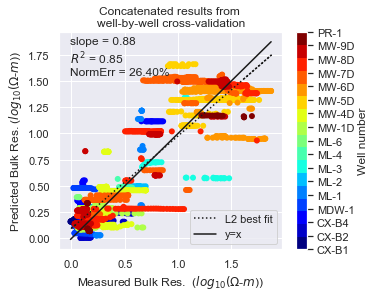

<Figure size 432x288 with 0 Axes>

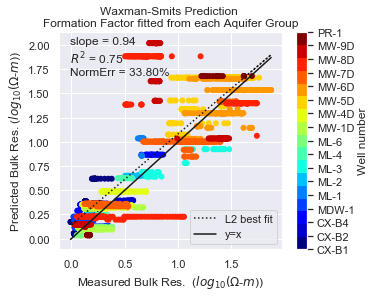

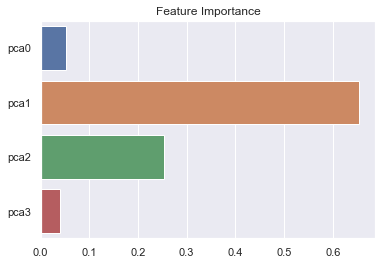

In [1230]:
# #Plot 
# wellids = df2.Well.unique()

# for nam,y_test,y_predict in zip(wellids,y_tests,y_preds):
#     plt.scatter(y_test,y_predict,label=nam)
# plt.legend(loc=(1.05,.5))

# c = np.concatenate( y_color, axis=0 )
c = [welldict[nam] for nam in df_testing.Well]
cmap = cm.get_cmap('jet',len(np.unique(c)))

# bin_wiggle(y_predict,binsize=.1),
# y_pred = np.log10(1/np.power(10,(np.concatenate( y_preds, axis=0 )/10)))
# y_test = np.log10(1/np.power(10,(np.concatenate( y_tests, axis=0 )/10)))

# y_test= df_testing.logrild.values


y_pred_RF = np.concatenate( y_preds, axis=0 )
y_pred = y_pred_RF
y_test = df_testing.logrild

# y_test = df_testing.logrild

# y_pred = np.concatenate( y_preds, axis=0 )/10
# y_test = np.concatenate( y_tests, axis=0 )/10


# y_pred = np.log10(1/np.power(10,(np.concatenate( y_preds, axis=0 ))))
# y_test = np.log10(1/np.power(10,(np.concatenate( y_tests, axis=0 ))))



f,ax = x_y_regression(y_test,
                      y_pred,
#                         bin_wiggle(np.concatenate( y_tests, axis=0 )),
#                       np.concatenate( y_preds, axis=0 ),                      
#                         bin_wiggle(np.concatenate( y_tests, axis=0 )),
#                       bin_wiggle(np.concatenate( y_preds, axis=0 ),binsize=.1),
                      c,
                      plotslp=True,slpname='slope',plotone2one=True,
                      edgecolors='k',linewidth=0,cmap=cmap)#,vmin=25,vmax=100);
plt.xlabel('Measured Bulk Res.  ($log_{10}(\Omega$-$m$))')
plt.ylabel('Predicted Bulk Res. ($log_{10}(\Omega$-$m$))')
plt.title('Concatenated results from \nwell-by-well cross-validation')
plt.legend(loc='lower right')
cb = plt.colorbar()
cb.ax.set_ylabel('Well number')
ticks=  [num for nam,num in welldict.items() if (nam in allwells)]
ticklabels = [nam for nam,num in welldict.items() if (nam in allwells)]
# ticklabels = [nam for num,nam in enumerate(aq_names)]

cb.set_ticks(ticks)
cb.set_ticklabels(ticklabels)
# sns.kdeplot(np.concatenate( y_tests, axis=0 ),bin_wiggle(np.concatenate( y_preds, axis=0 ),binsize=.1),n_levels=20,shade=False,shade_lowest=False)
# # plt.axis('off')
# plt.xlim([-1.25,2])
# plt.ylim([-1.25,2])

plt.show()

y_test = np.log10(df2.RILD.values)
y_pred = df2.logrild_pred_ws.values
c = np.asarray([welldict[nam] for nam in df2.Well])


msk=~np.isnan(y_pred)
y_test = y_test[msk]
y_pred = y_pred[msk]
c = c[msk]
cmap = cm.get_cmap('jet',len(np.unique(c)))

f,ax= x_y_regression(y_test,
                    y_pred,
                    c,
                    plotone2one=True,
                    slpname='slope',edgecolors='k',linewidth=0,cmap=cmap)#,vmin=25,vmax=100);
plt.xlabel('Measured Bulk Res.  ($log_{10}(\Omega$-$m$))')
plt.ylabel('Predicted Bulk Res. ($log_{10}(\Omega$-$m$))')
plt.title('Waxman-Smits Prediction \nFormation Factor fitted from each Aquifer Group')
plt.legend(loc='lower right')
cb = plt.colorbar()
cb.ax.set_ylabel('Well number')
ticks=  [num for nam,num in welldict.items() if (nam in allwells)]
ticklabels = [nam for nam,num in welldict.items() if (nam in allwells)]
# ticklabels = [nam for num,nam in enumerate(aq_names)]
cb.set_ticks(ticks)
cb.set_ticklabels(ticklabels)
plt.legend(loc='lower right')
# plt.xlim([-1.25,2])
# plt.ylim([-1.25,2])

# plt.savefig(figdir.joinpath('CVwell_noclay2.png'),dpi=300,bbox_inches='tight')
plt.show()

plt.figure()
scores = 0
for i in range(len(estimator.estimators_)):
    scores += np.asarray(estimator.estimators_).flatten()[i].feature_importances_
scores /= n_repeat
sns.barplot(x=scores,y=X_test.columns)c
plt.title('Feature Importance');
# plt.savefig(figdir.joinpath('FeatureImportance.png'),bbox_inches='tight',dpi=300)
# export_tree(figdir,estimator.estimators_[0],max_depth=5,predictors=predictors,prefix='Tree_')

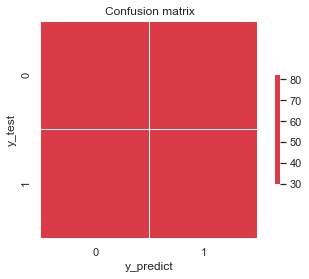

In [1094]:
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(np.concatenate(y_tests,axis=0).astype(int),np.concatenate(y_preds,axis=0).astype(int))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(conf, cmap=cmap, vmax=30, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.xlabel('y_predict')
plt.ylabel('y_test')
plt.title('Confusion matrix')
plt.show()

In [1231]:
def load_obj(dirname,name):
    with open(Path(dirname).joinpath(name + '.pkl').as_posix(), 'rb') as f:
        return pickle.load(f)

def save_obj(dirname,obj,name):
    with open(Path(dirname).joinpath(name + '.pkl').as_posix(), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
def inverse_transform_sampling(data, n_bins=40, n_samples=100):
    hist, bin_edges = np.histogram(data, bins=n_bins, density=True)
    cum_values = np.zeros(bin_edges.shape)
    cum_values[1:] = np.cumsum(hist*np.diff(bin_edges))
    inv_cdf = interpolate.interp1d(cum_values, bin_edges)
    r = np.random.rand(n_samples)
    return inv_cdf(r)



In [1232]:
df_testing = df_testing.assign(preds = np.concatenate( y_preds, axis=0 ))
# df_testing = df_testing.assign(Lconf95=np.concatenate(errs,axis=1)[0])
# df_testing = df_testing.assign(Uconf95=np.concatenate(errs,axis=1)[1])
df_testing = df_testing.assign(logrild_pred_RF=y_pred_RF)
df_testing = df_testing.assign(err=  df_testing.logrild - df_testing.logrild_pred_RF)
df_testing = df_testing.assign(err_sq=  np.power(df_testing.err,2))
df_testing = df_testing.assign(err_ws= np.abs(df_testing.logrild - df_testing.logrild_pred_ws) - np.abs(df_testing.logrild - df_testing.logrild_pred_RF))
df_testing.to_pickle(auxdir.joinpath('df_testing_xval'))
save_obj(auxdir,estimators,'estimators_xval')


# n_samples= 10
# bin_centers = estimator.classes_
# dx=(bin_centers[1]-bin_centers[0])/2
# # bin_edges = np.r_[bin_centers - dx/2,bin_centers[-1]+dx/2]
# # samps = [inverse_transform_sampling(prob,n_bins=bin_edges,n_samples=n_samples) for prob in estimator.predict_proba(X_train)]
# # samps = np.asarray(samps)
# # save_obj(auxdir,samps,'samps_xval')


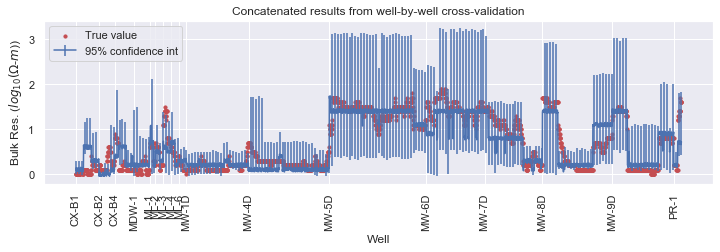

In [764]:
#Plot 95% confindence interval of prediction by looping through predictors...
lables=[]
ticks=[]
for well in allwells:
    lables.append(well)
    ticks.append(np.where(df_testing.Well==well)[0][0])

f,ax = plt.subplots(1,1,figsize=(12,3))
y = bin_wiggle(np.concatenate( y_preds, axis=0 ),binsize=.1)
x= np.arange(len(y))
plt.errorbar(x,y,np.concatenate(errs,axis=1),errorevery=15,capthick=20,label='95% confidence int')
plt.scatter(x,np.concatenate( y_tests, axis=0 ),c='r',s=10,label='True value')
plt.xticks(ticks,lables,rotation=90)
plt.ylabel('Bulk Res. ($log_{10}(\Omega$-$m$))')
plt.xlabel('Well')
plt.title('Concatenated results from well-by-well cross-validation')
plt.legend(loc='upper left')
# plt.savefig(figdir.joinpath('95pct_conf.png'),bbox_inches='tight',dpi=300)

(array([  8., 121., 232., 835., 999., 602.,  41., 140.,  35., 108.]),
 array([-0.78956602, -0.57650061, -0.36343519, -0.15036978,  0.06269563,
         0.27576105,  0.48882646,  0.70189187,  0.91495728,  1.1280227 ,
         1.34108811]),
 <a list of 10 Patch objects>)

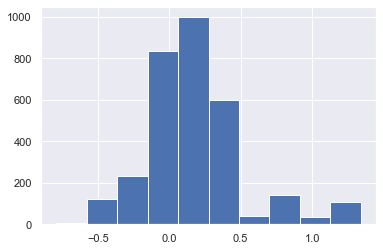

In [848]:
plt.hist(df_testing.loc[:,'logrild_pred_ws'] - df_testing.loc[:,'logrild_pred_RF'])

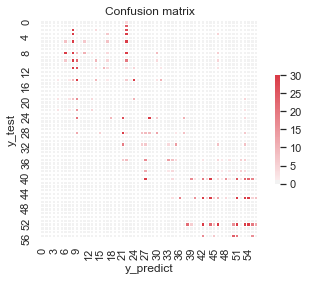

In [872]:
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(np.round(np.concatenate(y_tests,axis=0)*10).astype(int),np.round(np.concatenate(y_preds,axis=0)*10).astype(int))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(conf, cmap=cmap, vmax=30, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.xlabel('y_predict')
plt.ylabel('y_test')
plt.title('Confusion matrix')
plt.show()

### Train on Marina, Predict Soquel 

In [571]:
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,GradientBoostingClassifier
np.random.seed(1)

n_repeat = 500     # Number of iterations for computing expectations
n_estimators = n_repeat
max_depth = 10


####Choose the input data set#########
#Predict from water quality samples and lith
predicted = 'logrild_conv_bin'
train_test_cols=predicted

predictors = ['FBS','aq_groupnum','X','Y','C']
colorcolumn = 'aq_groupnum'
# estimator=BaggingClassifier(DecisionTreeClassifier(
#     max_depth=max_depth,max_leaf_nodes=100),n_estimators=n_estimators,bootstrap_features=False)
# estimator = BaggingRegressor(DecisionTreeRegressor(max_depth=max_depth))
# estimator=GradientBoostingClassifier(n_estimators=n_estimators,max_depth=max_depth)
estimator=RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,min_samples_leaf=1,oob_score=True,max_features=2)


y_preds = []
y_tests = []
y_color = []

list_of_conditions = (df2.RILD.notnull(),
                      df2.FBS.notnull(),
                      df2.lith.notnull(),
                      df2.Sb_a.notnull(),
                      df2.Sb_b.notnull(),
                      df2.Y.notnull())
df_testing = df2[nested_logicals(df2,list_of_conditions,func=np.logical_and)]

df_testing = df_testing.assign(logrhoEC_est = np.log10(df_testing.loc[:,'Rw_est']))
df_testing = df_testing.assign(Region_bin = df_testing.loc[:,'Region']=='Marina')
df_testing = df_testing.assign(logrhoEC1f = np.log10(cond2rho(df_testing.loc[:,'EC1f'])))
df_testing = df_testing.assign(logrild = np.log10(df_testing.RILD))
df_testing = df_testing.assign(logrild_bin = (np.round(np.log10(df_testing.RILD),1)*10).values.astype(int))
df_testing = df_testing.assign(logrild_conv_bin = (np.round(df_testing.logrild_conv,1)*10).values.astype(int))
df_testing = df_testing.assign(logfres = np.log10(df_testing.FRES))
df_testing = df_testing.loc[df_testing.lithnum_bin_conv==1,:]

df_train = df_testing.loc[df_testing.Region=='Marina']
df_test = df_testing.loc[df_testing.Region=='Soquel']

X_train = df_train.loc[:,predictors]
y_train = df_train.loc[:,predicted]

X_test = df_test.loc[:,predictors]
y_test = df_test.loc[:,'logrild']

estimator.fit(X_train,y_train)
y_predict = estimator.predict(X_test)
y_train_predict = estimator.predict(X_train)


y_train = y_train/10
y_predict = y_predict/10
y_train_predict = y_train_predict/10


/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in log10


In [781]:
#Plot
c = [welldict[nam] for nam in df_test.Well]
cmap = cm.get_cmap('jet',len(np.unique(c)))
f,ax = x_y_regression(y_test,
                      bin_wiggle(y_predict,binsize=.1),
                      c,
                      plotslp=True,slpname='slope',plotone2one=True,
                      edgecolors='k',linewidth=0,cmap=cmap)#,vmin=25,vmax=100);
plt.xlabel('Measured Bulk Res.  ($log_{10}(\Omega$-$m$))')
plt.ylabel('Predicted Bulk Res. ($log_{10}(\Omega$-$m$))')
plt.title('Concatenated results from \nwell-by-well cross-validation')
plt.legend(loc='lower right')
cb = plt.colorbar()
cb.ax.set_ylabel('Well number')
ticks=  [num for nam,num in welldict.items() if (nam in allwells)]
ticklabels = [nam for nam,num in welldict.items() if (nam in allwells)]

cb.set_ticks(ticks)
cb.set_ticklabels(ticklabels)


c = [welldict[nam]  for nam in df_train.Well]
# c = df_train.DEPT

cmap = cm.get_cmap('jet',len(np.unique(c)))
f,ax = x_y_regression(df_train.logrild,
                      bin_wiggle(y_train_predict,binsize=.1),
                      c,
                      plotslp=True,slpname='slope',plotone2one=True,
                      edgecolors='k',linewidth=0,cmap=cmap)#,vmin=25,vmax=100);
plt.xlabel('Measured Bulk Res.  ($log_{10}(\Omega$-$m$))')
plt.ylabel('Predicted Bulk Res. ($log_{10}(\Omega$-$m$))')
plt.title('Concatenated results from \nwell-by-well cross-validation')
plt.legend(loc='lower right')
cb = plt.colorbar()
cb.ax.set_ylabel('Well number')
ticks=  [num for nam,num in welldict.items() if (nam in allwells)]
ticklabels = [nam for nam,num in welldict.items() if (nam in allwells)]

cb.set_ticks(ticks)
cb.set_ticklabels(ticklabels)


# plt.savefig(figdir.joinpath('CVwell_noclay2.png'),dpi=300,bbox_inches='tight')
plt.show()

plt.figure()
scores = 0
for i in range(len(estimator.estimators_)):
    scores += np.asarray(estimator.estimators_).flatten()[i].feature_importances_
scores /= n_repeat
sns.barplot(x=scores,y=X_test.columns)
plt.title('Feature Importance');
# plt.savefig(figdir.joinpath('FeatureImportance.png'),bbox_inches='tight',dpi=300)
# export_tree(figdir,regs[0],max_depth=5,predictors=predictors,prefix='Tree_',feature_names=predictors)

ValueError: all the input array dimensions except for the concatenation axis must match exactly

Training on Marina data and testing on Soquel data is not very informative, since the Soquel dataset has so few distinctive features (X, Y, and aq_groupnum are the same throughout, FBS is basically the only feature on which to distinguish

### Error analysis: where are the high errors coming from?

In [1115]:
from scipy.stats import hmean
def harm_avg(fine_data,grid,background=10):
    coarse_data = background*np.ones(len(grid))
    for i,g in enumerate(grid[:-1]):
        avg_data = fine_data.loc[np.logical_and(fine_data.index<grid[i+1], fine_data.index > grid[i])]
        if len(avg_data>0):
            coarse_data[i] = hmean(avg_data)[0]
    return coarse_data



nam='MW-6D'
s=df_plot.loc[df_plot.Well==nam,'logrild']
d=df_plot.loc[df_plot.Well==nam,'DEPT']


hmean((s.values)[:10])


1.5746330328985885

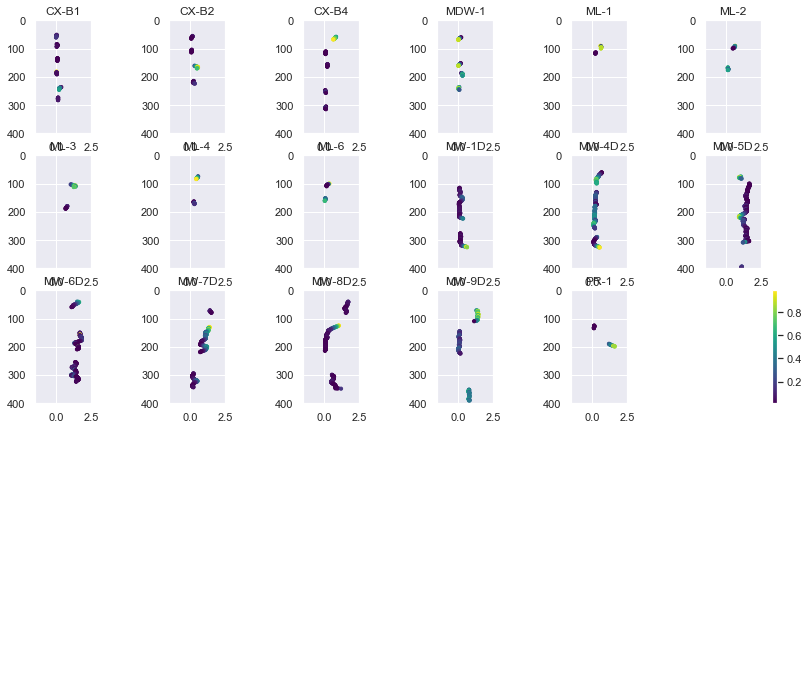

In [986]:
df_plot = df_testing
s=10
f,axs=plt.subplots(5,6,figsize=(14,12))
plt.set_cmap('viridis')
for i,nam in enumerate(allwells):
    ax =  axs.flatten()[i]
    plt.sca(ax)
    if i == axs.size-1:
        plt.axis('off')
        continue
    ax.set_xlim([-1.5,2.5])
    ax.set_ylim([0,400])
    ax.invert_yaxis()
    d=df_plot.loc[df_plot.Well==nam,'DEPT']
    s1=plt.scatter(df_plot.loc[df_plot.Well==nam,'logrild_conv'],d,
                s=s, label='Bulk Res.',c=df_plot.loc[df_plot.Well==nam,'err_sq'])#,vmin= -0.078438,vmax=0.186663)
#     tds1 = plt.scatter(np.log10(cond2rho(df_plot.loc[nam].loc[:,'EC1'])),df.loc[nam].index,
#                        c='k',s=3*s,label='Water Sample Res.',vmin=0, vmax=15000)
#     plt.ylabel('Depth (ft)')
#     plt.xlabel('Bulk Res. ($log_{10}(\Omega$-$m$))');
    ax.set_aspect(1/50)
    plt.title(nam);
#     if i== axs.size-2:
#         lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        
flag=0
for ax in axs.flatten()[len(allwells):]:
    plt.sca(ax)
    plt.axis('off')
    if flag==0:
        plt.colorbar(s1)
        flag=1
# plt.savefig(figdir.joinpath('All_logs_lithology_bin.png'),dpi=500)

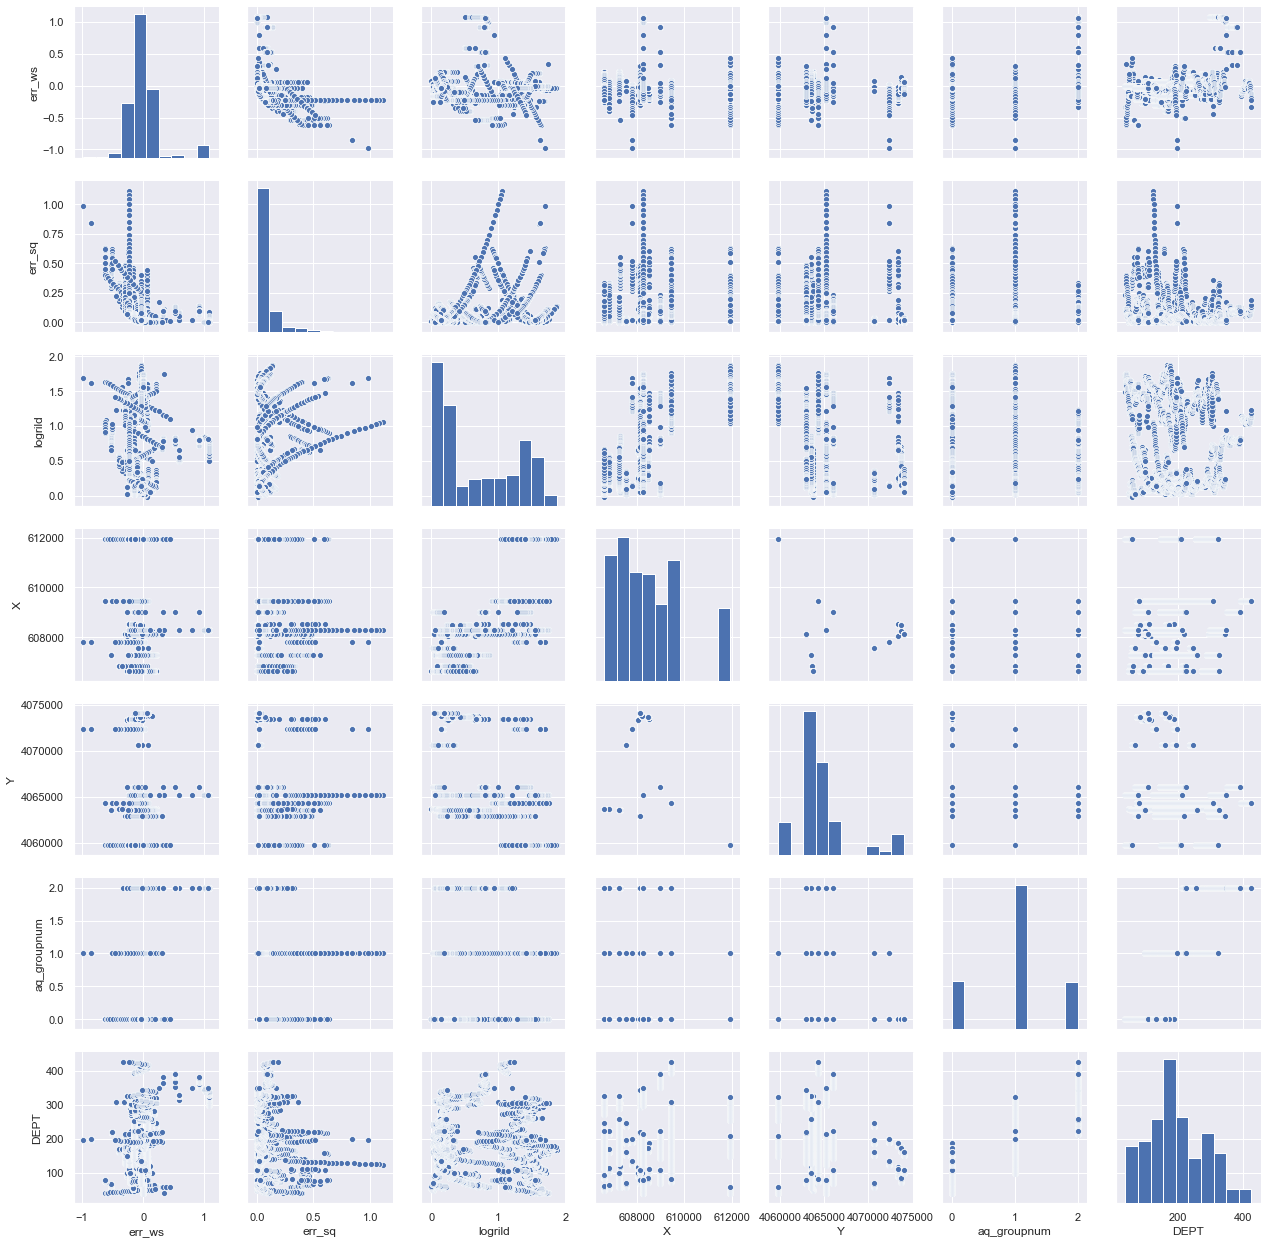

In [987]:
g = sns.pairplot(df_testing.loc[:,['Well','err_ws','err_sq','logrild','X','Y','aq_groupnum','DEPT']])
# g.map_lower(sns.kdeplot, cmap="Blues_d")
plt.show()

In [980]:
df_testing = df_testing.assign(err=  df_testing.logrild - df_testing.logrild_pred_RF)
# df_testing = df_testing.assign(err_sq=  (np.concatenate(y_tests,axis=0) - np.concatenate(y_preds,axis=0))**2)
# df_testing = df_testing.assign(err_ws= np.abs(df_testing.logrild - df_testing.logrild_pred_ws) - np.abs(df_testing.logrild - df_testing.logrild_pred_RF))
`b
df_testing.

AttributeError: module 'pandas' has no attribute 'sortby'

In [988]:
df_testing.sort_values('err_sq',ascending=False).head(40)

,Well,DEPT,RILM,RILD,GR,SP,X,Y,Region,lith,...,logrild_bin,logrild_conv_bin,logfres,preds,Lconf95,Uconf95,logrild_pred_RF,err_ws,err,err_sq
7992,MW-8D,125.0,6.8660,11.3670,68.449,51.277,608265.029400,4.065209e+06,Marina,SP,...,11,11,0.601734,0,0.00,0.3,0.0,-0.225562,1.055646,1.114388
7993,MW-8D,125.5,6.7154,10.9670,70.671,49.825,608265.029400,4.065209e+06,Marina,SP,...,10,10,0.605413,0,0.00,0.3,0.0,-0.225562,1.040088,1.081783
7994,MW-8D,126.0,6.4590,10.5710,69.813,48.949,608265.029400,4.065209e+06,Marina,SP,...,10,10,0.609061,0,0.00,0.3,0.0,-0.225562,1.024116,1.048814
7995,MW-8D,126.5,6.2012,10.0610,63.328,49.119,608265.029400,4.065209e+06,Marina,SP,...,10,10,0.612678,0,0.00,0.3,0.0,-0.225562,1.002641,1.005289
9634,PR-1,197.0,13.3290,49.2300,44.322,-922.590,607791.255008,4.072317e+06,Marina,SM,...,17,15,NaN,7,0.60,1.7,0.7,-0.980179,0.992230,0.984520
7996,MW-8D,127.0,5.9288,9.4954,56.597,49.906,608265.029400,4.065209e+06,Marina,SP,...,10,10,0.616160,0,0.00,0.3,0.0,-0.225562,0.977513,0.955532
7997,MW-8D,127.5,5.5993,8.9455,56.962,50.691,608265.029400,4.065209e+06,Marina,SP,...,10,9,0.619719,0,0.00,0.3,0.0,-0.225562,0.951605,0.905551
7998,MW-8D,128.0,5.2693,8.3957,60.952,51.482,608265.029400,4.065209e+06,Marina,SP,...,9,9,0.623249,0,0.00,0.3,0.0,-0.225562,0.924057,0.853881
9639,PR-1,199.5,49.2300,41.5270,44.322,-924.230,607791.255008,4.072317e+06,Marina,SM,...,16,16,NaN,7,0.60,1.7,0.7,-0.856482,0.918331,0.843331
9638,PR-1,199.0,49.2300,41.5270,44.322,-926.160,607791.255008,4.072317e+06,Marina,SM,...,16,16,NaN,7,0.60,1.7,0.7,-0.856482,0.918331,0.843331


In [272]:
y_all = df_testing.loc[:,predicted]
df_train, df_test, y_train, y_test = train_test_split(df_testing, y_all, test_size=train_ratio)

y_test = y_test.loc[:,'logrild']

X_test = df_test.loc[:,predictors]
regs = []
X_train = []
y_train = []
for i in range(n_repeat):
    samp = resample(df_train,replace=True)
    X_train.append(samp.loc[:,predictors])
    y_train.append(samp.loc[:,[train_test_cols[0]]])

# Compute predictions
y_predict = np.zeros((len(y_test), n_repeat))

for i in range(n_repeat):
    regs.append(estimator(**kwargs))
    regs[-1].fit(X_train[i], y_train[i])
    y_predict[:, i] = regs[-1].predict(X_test)


y_est = y_predict.mean(axis=1)
y_error = np.zeros(y_test.size)

# Bias^2 + Variance + Noise decomposition of the mean squared error
y_error = np.power(y_test.values - y_predict,2).mean(axis=1)
y_noise = 0 # didn't bootstrap the test values np.var(y_test.values)
y_bias = (y_test.values.flatten() - np.mean(y_predict, axis=1))**2
y_var = np.var(y_predict,axis=1)

print("{0:.4f} (MSE) = {1:.4f} (bias^2)"
      "+ {2:.4f} (var)".format(np.mean(y_error),
                               np.mean(y_bias),
                               np.mean(y_var)))
print("{0:.4f} (MSE) = {1:.2f}% (bias^2)"
      "+ {2:.2f}% (var)".format(np.mean(y_error),
                               100*np.mean(y_bias)/(np.mean(y_bias)+np.mean(y_var)),
                               100*np.mean(y_var)/(np.mean(y_bias)+np.mean(y_var))))


IndexingError: Too many indexers

### Uncertainty estimate: effect of changing the train/test groups

In [31]:
from numpy.linalg import norm
n_repeat = 100       # Number of iterations for computing expectations
train_ratio = .20
max_depth = 5


####Choose the input data set#########
# ## Predict from FRES and lith
# predicted = ['logrild']
# predictors = ['logfres','Sb']
# df_testing = df[np.logical_and(np.logical_and(df.RILD.notnull(),~np.isnan(np.log(df.FRES.values))),df.lith.notnull())]

#Predict from water quality samples and lith
predicted = ['logrild_bin','logrild']
train_test_cols=predicted

predictors = ['logrhoEC1f','aqnum','lithnum_bin_conv','DEPT']
colorcolumn = 'aqnum'
estimator=DecisionTreeClassifier
df_testing = df2[np.logical_and(np.logical_and(df2.RILD.notnull(),df2.EC1f.notnull()),df2.lith.notnull())]
#######################################

df_testing = df_testing.assign(logrhoEC1f = np.log10(cond2rho(df_testing.loc[:,'EC1f'])))
df_testing = df_testing.assign(logrild = np.log10(df_testing.RILD))
df_testing = df_testing.assign(logrild_bin = (np.round(np.log10(df_testing.RILD),1)*10).values.astype(int))
df_testing = df_testing.assign(logfres = np.log10(df_testing.FRES))

n_it = 100
MSE = []
norm_err=[]
for s in range(n_it):
    if np.mod(s,5)==0:
        print('iteration',s)
    np.random.seed(s)
    regs,y_predict,(df_train, df_test, X_train,X_test,y_train, y_test) = bagged_trees2(df_testing,predicted,predictors,
                                  train_ratio=train_ratio,
                                  train_test_cols=train_test_cols,
                                  n_repeat=n_repeat,
                                  verbose=False,  
                                  estimator=estimator,
                                  max_depth=max_depth)

    y_predict /=10
    MSE.append(np.power(y_predict - np.tile(y_test,n_repeat),2).mean())
    norm_err.append(norm(y_predict - np.tile(y_test.values,[1,n_repeat]),ord=2)
                    /norm(np.tile(y_test.values,[1,n_repeat]),ord=2))

/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in log10


iteration 0
iteration 5
iteration 10
iteration 15
iteration 20
iteration 25
iteration 30
iteration 35


KeyboardInterrupt: 

In [ ]:
# plt.hist(norm_err,label='Norm. Error')
sns.distplot(norm_err,label='Norm. Error')
plt.vlines(norm_err[0],0,25,colors='r',label='Displayed results')
plt.title('Normalized error versus random seed: {} iterations'
          .format(n_it))
plt.xlabel('normalized error')
plt.ylabel('count')
plt.legend()
# plt.savefig(figdir.joinpath('ErrorHist.png'),bbox_inches='tight',dpi=300)

Tree: 0.0250 (error) = 0.0001 (bias^2)  + 0.0149 (var) + 0.0100 (noise)
Bagging(Tree): 0.0196 (error) = 0.0004 (bias^2)  + 0.0092 (var) + 0.0100 (noise)


/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF: 0.0194 (error) = 0.0009 (bias^2)  + 0.0085 (var) + 0.0100 (noise)
Ada: 0.0240 (error) = 0.0027 (bias^2)  + 0.0113 (var) + 0.0100 (noise)


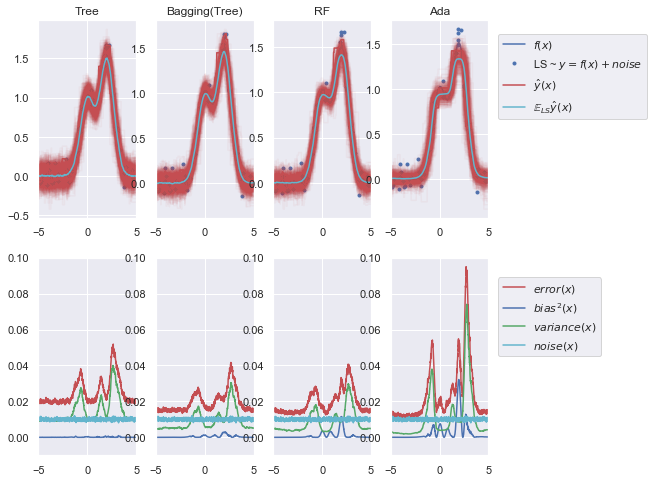

In [110]:
# Author: Gilles Louppe <g.louppe@gmail.com>
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import BaggingRegressor, RandomForestRegressor,AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

# Settings
n_repeat = 200       # Number of iterations for computing expectations
n_train = 50        # Size of the training set
n_test = 1000       # Size of the test set
noise = 0.1         # Standard deviation of the noise
np.random.seed(1)

# Change this for exploring the bias-variance decomposition of other
# estimators. This should work well for estimators with high variance (e.g.,
# decision trees or KNN), but poorly for estimators with low variance (e.g.,
# linear models).
estimators = [("Tree", DecisionTreeRegressor()),
               ("Bagging(Tree)", BaggingRegressor(DecisionTreeRegressor())),
               ("RF", RandomForestRegressor(max_depth=5)),
             ("Ada",AdaBoostRegressor())]

n_estimators = len(estimators)


# Generate data
def f(x):
    x = x.ravel()

    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)


def generate(n_samples, noise, n_repeat=1):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X)

    if n_repeat == 1:
        y = f(X) + np.random.normal(0.0, noise, n_samples)
    else:
        y = np.zeros((n_samples, n_repeat))

        for i in range(n_repeat):
            y[:, i] = f(X) + np.random.normal(0.0, noise, n_samples)

    X = X.reshape((n_samples, 1))

    return X, y


X_train = []
y_train = []

for i in range(n_repeat):
    X, y = generate(n_samples=n_train, noise=noise)
    X_train.append(X)
    y_train.append(y)

X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)

plt.figure(figsize=(10, 8))

# Loop over estimators to compare
for n, (name, estimator) in enumerate(estimators):
    # Compute predictions
    y_predict = np.zeros((n_test, n_repeat))

    for i in range(n_repeat):
        estimator.fit(X_train[i], y_train[i])
        y_predict[:, i] = estimator.predict(X_test)

    # Bias^2 + Variance + Noise decomposition of the mean squared error
    y_error = np.zeros(n_test)

    for i in range(n_repeat):
        for j in range(n_repeat):
            y_error += (y_test[:, j] - y_predict[:, i]) ** 2

    y_error /= (n_repeat * n_repeat)

    y_noise = np.var(y_test, axis=1)
    y_bias = (f(X_test) - np.mean(y_predict, axis=1)) ** 2
    y_var = np.var(y_predict, axis=1)

    print("{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
          " + {3:.4f} (var) + {4:.4f} (noise)".format(name,
                                                      np.mean(y_error),
                                                      np.mean(y_bias),
                                                      np.mean(y_var),
                                                      np.mean(y_noise)))

    # Plot figures
    plt.subplot(2, n_estimators, n + 1)
    plt.plot(X_test, f(X_test), "b", label="$f(x)$")
    plt.plot(X_train[0], y_train[0], ".b", label="LS ~ $y = f(x)+noise$")

    for i in range(n_repeat):
        if i == 0:
            plt.plot(X_test, y_predict[:, i], "r", label=r"$\^y(x)$")
        else:
            plt.plot(X_test, y_predict[:, i], "r", alpha=0.05)

    plt.plot(X_test, np.mean(y_predict, axis=1), "c",
             label=r"$\mathbb{E}_{LS} \^y(x)$")

    plt.xlim([-5, 5])
    plt.title(name)

    if n == n_estimators - 1:
        plt.legend(loc=(1.1, .5))

    plt.subplot(2, n_estimators, n_estimators + n + 1)
    plt.plot(X_test, y_error, "r", label="$error(x)$")
    plt.plot(X_test, y_bias, "b", label="$bias^2(x)$"),
    plt.plot(X_test, y_var, "g", label="$variance(x)$"),
    plt.plot(X_test, y_noise, "c", label="$noise(x)$")

    plt.xlim([-5, 5])
    plt.ylim([-.01, 0.1])

    if n == n_estimators - 1:
        plt.legend(loc=(1.1, .5))

plt.subplots_adjust(right=.75)
plt.show()